#### Parton Shower

In [196]:
from random import * 
import math 
import numpy as np 
import scipy 
from scipy import optimize
from matplotlib import pyplot as plt
from tqdm import tqdm 
from scipy.integrate import quad # for numerical integrals
from alphaS import * 


Inizializzo $\alpha_S$ passando come riferimento la massa dello Z

In [197]:
aS=alphaS(0.118,91.186)

In [198]:
# RUN OPTIONS: parametri fondamentali

# Numero di linee di quark da simulare

Nevolve = 100000

# scala del cutoff
Qc = 1.

# the hard scale, e.g. 1000 GeV
Q = 1000.

Nel codice originale veniva data la possibilità di usare $\alpha_S(Q)$ fissa. Questo generava un numero troppo basso di emissioni, cosa non fisica. Quindi ho tolto questa possibilità dal codice.

In [199]:
scaleoption="pt" #alternativa 'pt' 
fixedscale=Q/2.


Let's now define:

- the splitting function, $P(z) = C_F \frac{1+z^2}{1-z}$, given by ```Pqq(z)```,
- the overestimate of the splitting function $\hat{P} = C_F\frac{2}{1-z}$, given by ```Pqq_over(z)```,
- il momento trasverso del gluone/quark $$
- la massa virtuale del quark iniziale $$
- a function that returns the scale of $\alpha_S$, according to the global variable ```scaleoption```, ```scale_of_alphaS```,
- the function that returns $\alpha_S$, accessed through ```LHAPDF```, ```alphaS```,
- and the function that gives the overestimate of $\alpha_S$, ```get_alphaS_over```. 

In [200]:
def Pqq(z):
    return CF*(1.+z**2)/(1.-z)

def Pqq_over(z):
    return 2*CF/(1.-z)

# calculate the transverse momentum of the emission

def Get_pTsq(t, z): return z**2 * (1-z)**2 * t

# calculate the virtual mass-squared of the emitting particle

def Get_mvirtsq(t,z): return z*(1-z) * t

def alphaS(t, z):

    if scaleoption == "pt":
        scale= z * (1-z) * math.sqrt(t)
    elif scaleoption == "fixed":
        scale= fixedscale
    
    if scale < Qc:
        return aS.alphasQ(Qc)/2./math.pi
    
    return aS.alphasQ(scale)/2./math.pi


def get_alphaS_over():
    
    if scaleoption == "pt":
        minscale = Qc # the minimum scale^2 available to the PDF
        scale = minscale
        
    elif scaleoption == "fixed":
        scale = fixedscale
        
    alphaS_over = aS.alphasQ(scale)/2./math.pi
    
    return alphaS_over




- the function $t \times \hat{\Gamma}(z) = \int_{\hat{z}_-}^{\hat{z}^+} \mathrm{d} z \frac{\hat{\alpha_S}}{2\pi} \hat{P}(z)=\int_{\hat{z}_-}^{\hat{z}^+} \mathrm{d} z \frac{\hat{\alpha_S}}{2\pi} C_F \frac{2}{1-z} =\frac{\hat{\alpha_S}}{2\pi} 2 C_F \log(\frac{1-\hat{z}^-}{1+\hat{z}^+})$, given by ```tGamma```.

  In realtà tGamma mi da $t \times \hat{\Gamma}(z) = \int_{}^{z} \mathrm{d} z' \frac{\hat{\alpha_S}}{2\pi} \hat{P}(z')=\int_{}^{z} \mathrm{d} z' \frac{\hat{\alpha_S}}{2\pi} C_F \frac{2}{1-z'}=-\frac{\hat{\alpha_S}}{2\pi} 2 C_F \log(1-z)$
- the inverse of the function $t \times \hat{\Gamma}(z)$, given by ```inversetGamma```,
- the overestimates of the limits of integration $\hat{z}_-$ and $\hat{z}_+$, given by ```zm_over``` and ```zp_over```:

  $\hat{z}_+(t)=1-\sqrt{\frac{Q_c^2}{t}}$

  $\hat{z}_-(t)=\sqrt{\frac{Q_c^2}{t}}$


In [201]:
def tGamma(z):
    return -2*get_alphaS_over()*CF*np.log(1.-z)

def Inverse_tGamma(y):
     return 1. - np.exp(- 0.5*y/CF/get_alphaS_over())

def rho(z1,z2):
    return tGamma(z1)-tGamma(z2)

#ancora non ho capito da dove arrivano questi 

def zp_over(t):
    return 1-np.sqrt(Qc**2/t)
def zm_over(t):
    return np.sqrt(Qc**2/t)


def Get_zEmission(t,R):
    return Inverse_tGamma(tGamma(zm_over(t))+R*( tGamma(zp_over(t))-tGamma(zm_over(t)) ))



Given the above, the treatment now proceeds as follows:

The overstimate of the Sudakov form factor is given by:

$\hat{\Delta}(t, t_\mathrm{max}) = \exp\left\{ - \int^{t_\mathrm{max}}_{t} \mathrm{d}t' \hat{\Gamma} (t') \right\}$,

with:

$\hat{\Gamma} (t') = \frac{1}{t'}   \int_{\hat{z}_-}^{\hat{z}^+} \mathrm{d} z \frac{\hat{\alpha_S}}{2\pi} \hat{P}(z)$.

We are working with the overestimated functions, and this allows us to analytically solve:

$\hat{\Delta}(t, t_\mathrm{max}) = R$, 

where $R$ is a random number in $[0,1]$. 

Therefore, we are seeking the solution of:

$\exp\left\{ - \int^{t_\mathrm{max}}_{t} \mathrm{d}t' \hat{\Gamma} (t') \right\} = R$,

or:

$\int^{t_\mathrm{max}}_{t} \mathrm{d}t' \hat{\Gamma} (t') = \ln\left(\frac{1}{R}\right)$.

Definiamo la funzione  $\rho({\hat{z(t')}_+},{\hat{z(t')}_-}) = \int_{\hat{z}_-}^{\hat{z}^+} \mathrm{d} z \frac{\hat{\alpha_S}}{2\pi} \hat{P}(z) = t'\hat{\Gamma} (t') $, to obtain:

$\int^{t_\mathrm{max}}_{t} \frac{\mathrm{d}t'}{t'} \rho(t') = \ln\left(\frac{1}{R}\right)$, 

or:

$\int^{t_\mathrm{max}}_{t'} \mathrm{d}\ln t' \rho(t) = \ln\left(\frac{1}{R}\right)$.

If the limit overestimates in $\rho({\hat{z}_+},{\hat{z}_-})$ do not depend on $t'$, then: 

$\left. \rho \ln t \right|_t^{t_\mathrm{max}} = \ln\left(\frac{1}{R}\right) \Rightarrow \rho \ln \frac{t_\mathrm{max}}{t}  = \ln\left(\frac{1}{R}\right) $, 

which yields after exponentiation:

$t =  t_\mathrm{max} R^{1/\rho}$.

In the numerical evaluation of $t$, we instead focus on:

$\ln \frac{t}{t_\mathrm{max}} = \frac{1}{\rho} \ln R$,

and construct the function:

$E(t) = \ln \frac{t}{t_\mathrm{max}} - \frac{1}{\rho} \ln R$,

where now, explicitly, $\rho({\hat{z}_+},{\hat{z}_-}) = \int_{\hat{z}_-}^{\hat{z}_+} \mathrm{d} z \frac{\hat{\alpha_S}}{2\pi} \hat{P}(z) = \int^{\hat{z}_+} \mathrm{d} z \frac{\hat{\alpha_S}}{2\pi} \hat{P}(z) - \int^{\hat{z}_-} \mathrm{d} z \frac{\hat{\alpha_S}}{2\pi} \hat{P}(z)$.

The function ```EmissionScaleFunc``` in the code that follows corresponds to $E(t)$ and the $\rho$ function is calculated via: ```r = tGamma(zp_over(t, Qc), aSover) - tGamma(zm_over(t, Qc), aSover)```. 

The "next" value of $t$ is then calculated by solving $E(t)=0$ in the function ```Get_tEmission```. This is done numerically via ```scipy.optimize.ridder```. 

The ```Get_tEmission``` function actually finds the value of $\ln(t/t_\mathrm{max})$ for which the solution is obtained, and therefore needs to be exponentiated and multiplied by $t_\mathrm{max}$ (represented by ```Q**2```) to get the value of $t$. 

In [202]:
def EmissionScaleFunc(logt_over_Qsq,Q,R):

    t = Q**2 * np.exp( logt_over_Qsq )
    
    r=rho(zp_over(t),zm_over(t))

    return logt_over_Qsq-(1./r)*np.log(R)

# una funzione che calcola numericamente la scala di emissione t dato la scala iniziale Q (il t da cui si parte), il cutoff Qc e un numero casuale R

def Get_tEmission(Q, tfac,R):

    tolerance = 1E-3 # the tolerance for the solution

    EmissionFunc_arg = lambda x : EmissionScaleFunc(x, Q,R) # the function in a form appropriate for the solver

    # calculate the solution using "Ridder's" method

    lower_bound=np.log(tfac*Qc**2/Q**2)
    upper_bound=0.

    sol, results = scipy.optimize.ridder(EmissionFunc_arg, lower_bound, upper_bound, xtol=tolerance, full_output=True, maxiter=1000)

    tEm = Q**2 * np.exp( sol )

    # if a solution has not been found, terminate the evolution 
    #        
    if abs(EmissionFunc_arg(sol)) > tolerance:
            return Q**2, [], False
            
    # otherwise return the emission scale and continue
    return tEm, results, True

(613806.8199348958,
       converged: True
            flag: 'converged'
  function_calls: 8
      iterations: 3
            root: -0.041787923224764864,
 True)

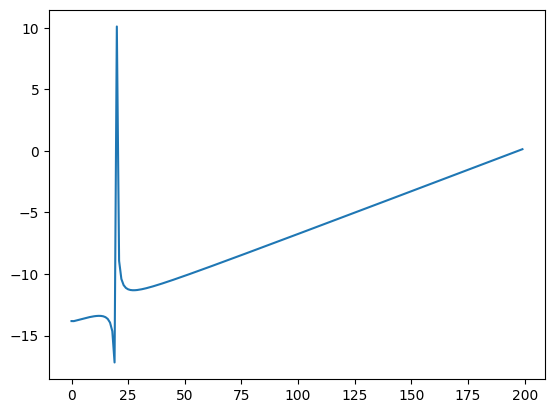

In [203]:
x=np.linspace(math.log(Qc**2/Q**2),0.1,200)
o=0.95
plt.plot(EmissionScaleFunc(x,Q,o))
Get_tEmission(800,3.99,o)


To get the $z$ variable, we need to solve:

$ \rho (z,{\hat{z}_-}) = R' \rho({\hat{z}_+},{\hat{z}_-})$,

where $R'$ is another random number in $[0,1]$. 

Recalling that: 

$t' \hat{\Gamma} (t') = \int_{\hat{z}_-}^{\hat{z}_+} \mathrm{d} z \frac{\hat{\alpha_S}}{2\pi} \hat{P}(z)$, 

we now define

$\tilde{\rho}(z) = \int^{z} \mathrm{d} z \frac{\hat{\alpha_S}}{2\pi} \hat{P}(z)$, we can write the equation for $z$ as:

$\tilde{\rho}(z) - \tilde{\rho}({\hat{z}_-}) = R' \left[ \tilde{\rho}({\hat{z}_+}) - \tilde{\rho}({\hat{z}_-}) \right]$,

and we obtain $z$ by solving:

$ z = \tilde{\rho}^{-1} \left\{ \tilde{\rho}({\hat{z}_-}) + R' \left[\tilde{\rho}({\hat{z}_+}) - \tilde{\rho}({\hat{z}_-}) \right] \right\}$,

where $\tilde{\rho}^{-1}$ is the inverse of $\tilde{\rho}$, which is given by the ```inversetGamma``` function in our code. 

The following function ```Generate_Emission``` solves for the next $t$ and $z$ using the overestimates, and then implements the vetoing by constructing a probability with the full splitting function and value of $\alpha_S$. 

In [204]:
# function that generates emissions:
def Generate_Emission(Q, tfac):
    
    generated = True

    R1 = random()
    R2 = random()
    R3 = random() #veto test over z
    R4 = random() #veto test
    
    # solve for the (candidate) emission scale:

    tEm, results, continueEvolution = Get_tEmission(Q,tfac,R1)
    

    # if no solution is found then end branch

    if continueEvolution == False:
        zEm = 1.
        pTsqEm = 0.
        MsqEm = 0.
        return tEm, zEm, pTsqEm, MsqEm, generated, continueEvolution

    
    
    # get the (candidate) z of the emission
    zEm = Get_zEmission(tEm,R2)
    
    # get the transverse momentum 
    pTsqEm = Get_pTsq(tEm, zEm)

    

    # now check the conditions to accept or reject the emission:
    # check if the transverse momentum is physical:
    if pTsqEm < 0.:
      
        generated = False
        
    # compare the splitting function overestimate prob to a random number
    if Pqq(zEm)/Pqq_over(zEm) < R3:
        generated = False
    
    # compare the alphaS overestimate prob to a random number
    if alphaS(tEm, zEm)/get_alphaS_over() < R4:
        generated = False
    
    # get the virtual mass squared:
    MsqEm = Get_mvirtsq(tEm, zEm)
    if generated == False: # rejected emission
        zEm = 1.
        pTsqEm = 0.
        MsqEm = 0.
    # return all the variables for the emission
    return tEm, zEm, pTsqEm, MsqEm, generated, continueEvolution

The above function generates the next emission scale and momentum fraction. To get the full evolution, the main function uses it, until the cutoff scale is reached. 

Note that the next evolution scale is set to $\tilde{t} z^2$ in order to implement angular ordering in the branchings

In [205]:
# the function that performs the evolution of a single branch:
# returns a list of all the emissions for further processing

def Evolve(Q):
    # the minimum evolution scale
    tEm_min = Qc**2
    # counter for the number of emissions:
    Nem = 0
    # array to store emission info:
    Emissions = []

    fac_tEm = 3.999 # minimum value for the cutoff to try emissions = fac_tEm * Qc**2 (should be less than the actual cutoff)
    fac_cutoff = 4. # actual cutoff = fac_cutoff * Qc**2

    # start the evolution

    tEm = Q**2 # initial value of the evolution variable
    zEm = 1 # initial value of the momentum fraction

    

    while np.sqrt(tEm)*zEm > np.sqrt(fac_cutoff*tEm_min):
        # evolve:
        tEm, zEm, pTsqEm, MsqEm, generatedEmission, continueEvolution = Generate_Emission(np.sqrt(tEm)*zEm, fac_tEm)

        # if the solver could not find a solution, end the evolution
        if continueEvolution == False:
           return Emissions
        # if we have already passed the cutoff this emission does not count
        # this will also terminate the evolution
        if tEm < fac_cutoff*tEm_min: 
           
            zEm = 1.
            pTsqEm = 0.
            QsqEm = 0.
        
            return Emissions

        # if the emission was successful, append to the Emissions list and continue
        if zEm != 1.0:
            
            Emissions.append([math.sqrt(tEm), zEm, math.sqrt(pTsqEm), math.sqrt(MsqEm)])
            Nem = Nem + 1
            
        

   
    return Emissions




In [206]:
##########################
# Evolution begins here! #
##########################

# set the overestimate of alphaS once and for all:

# list to store all emission information:
AllEmissions = []
N_Emissions=[]

print('Evolving', Nevolve, 'branches from Q=', Q, 'GeV --> Qc=', Qc, 'GeV')

# perform evolution over Nevolve branches:
for j in tqdm(list(range(Nevolve))): # tqdm is the progress bar 
    # perform the evolution over a single branch j and return a list of all the emissions:
    
    Emissions =Evolve(Q)
    N_Emissions.append(len(Emissions))
  
    # concatenate the emissions of this evolution branch to the list of all emissions to plot
    AllEmissions = AllEmissions + Emissions

print('All evolutions ended')


Evolving 100000 branches from Q= 1000.0 GeV --> Qc= 1.0 GeV


 56%|█████▌    | 56000/100000 [04:50<05:28, 133.79it/s]

Let's compare the momentum fraction with the expected one from the full splitting function. Note that this will only be exact if the scale has been set to fixed, otherwise there will be some dependence of $\alpha_S$ on $z$ by using the $p_T$ of the emissions as its argument. 

(array([4.3449e+04, 3.2217e+04, 1.6485e+04, 5.8490e+03, 0.0000e+00,
        1.5950e+03, 3.3500e+02, 6.3000e+01, 6.0000e+00, 1.0000e+00]),
 array([0. , 0.8, 1.6, 2.4, 3.2, 4. , 4.8, 5.6, 6.4, 7.2, 8. ]),
 <BarContainer object of 10 artists>)

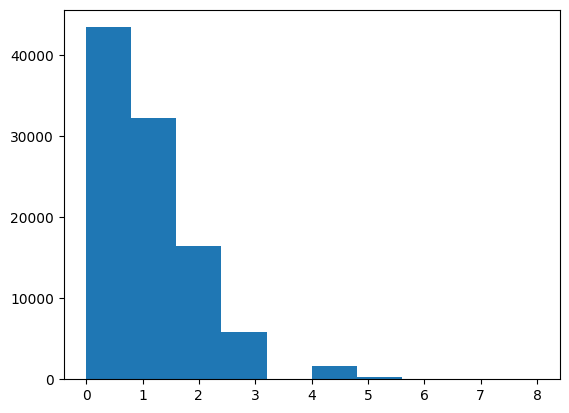

In [ ]:
plt.hist(N_Emissions)

---
plotting z of emissions
11.519552930481911
0.9358882753052508
11.519552930481911
11.519552930481911


[]

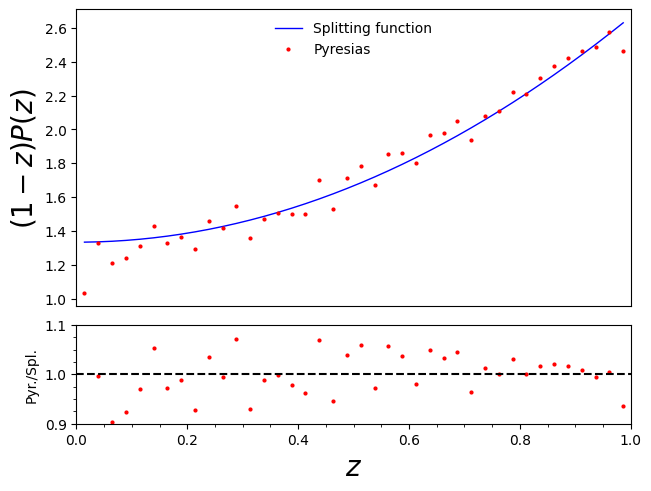

In [ ]:
ptarray=[]
marray=[]
zarray = []

for i in range(len(AllEmissions)):
    zarray.append(np.array(AllEmissions[i][1]))
    ptarray.append(np.array(AllEmissions[i][2]))
    marray.append(np.array(AllEmissions[i][3]))




###########################
print('---')
print('plotting z of emissions')
# plot settings ########
plot_type = 'momentumfrac'
# plot:
# plot settings
ylab = '$(1-z)P(z)$'
xlab = '$z$'
ylog = False
xlog = False
nbins=40
# construct the axes for the plot
fig = plt.figure(constrained_layout=True)

import matplotlib.gridspec as gridspec # more plotting 
from prettytable import PrettyTable # pretty printing of tables
from matplotlib.ticker import MultipleLocator

gs = gridspec.GridSpec(4, 4,figure=fig,wspace=0, hspace=0)
ax = fig.add_subplot(gs[:3, :])
ax2 = fig.add_subplot(gs[3, :])
gs.update(wspace=0,hspace=0)

ax.grid(False)
ax2.xaxis.set_minor_locator(MultipleLocator(0.05))
ax2.yaxis.set_minor_locator(MultipleLocator(0.025))



gs.update(wspace=0.0, hspace=0.0)

# get the histogram bins:
bins, edges = np.histogram(zarray, bins=nbins, density=True)

left,right = edges[:-1],edges[1:]
X = np.array([0.5*left+0.5*right]).T.flatten()
Y = np.array([bins]).T.flatten() * (1-X)
# normalise:
xnorm_min=0.0
xnorm_max=1.0

#Y = Y/np.linalg.norm(Y)/(Y[1]-Y[0])
#Ysum = Y[(X>xnorm_min) & (X<xnorm_max)].sum()
gs.update(wspace=0.0, hspace=0.0)


# compare to the input splitting function
# this comparison is only correct if alphaS is fixed
# this is because the scale of alphaS is also a function of z 
Yspl = Pqq(X) * (1-X)

# get the integral numerically, but not in the whole range
# since the splitting function diverges as z->1 and this cannot be captured numerically:
zp = X[(X<xnorm_max)][-1]
zm = X[(X>xnorm_min)][0]
def Pqq1mz(z):
    return Pqq(z) * (1-z)
YsplI = quad(Pqq1mz, 0, 1)
YsplI = np.linalg.norm(Yspl)
print(np.linalg.norm(Yspl))
ax.plot(X,Yspl, color='blue', lw=1, label='Splitting function', marker='x', ms=0)

# plot:
print(np.linalg.norm(Y))
Y = YsplI * Y / np.linalg.norm(Y)
print(np.linalg.norm(Y))
print(YsplI)

ax.plot(X,Y, label='Pyresias', color='red', lw=0, marker='o', ms=2)


# ratio:
ax2.plot(X,Y/Yspl, color='red', lw=0, label='Splitting function', marker='o', ms=2)
ax2.hlines(y=1, xmin=0, xmax=1, color='black', ls='--')

# set the ticks, labels and limits etc.
ax.set_ylabel(ylab, fontsize=20)
ax2.set_xlabel(xlab, fontsize=20)
ax2.set_ylabel('Pyr./Spl.')
ax2.set_ylim(0.9,1.1)
ax2.set_xlim(0.0,1.0)
ax.set_xlim(0.0,1.0)
# choose x and y log scales
if ylog:
    ax.set_yscale('log')
else:
    ax.set_yscale('linear')
if xlog:
    ax.set_xscale('log')
else:
    ax.set_xscale('linear')

# create legend and plot/font size
ax.legend()
ax.legend(loc="upper center", numpoints=1, frameon=False, prop={'size':10})
ax.set_xticklabels('')
ax.set_xticks([])
#infile = plot_type + '.dat'
#plt.savefig('plots/' + infile.replace('.dat','.pdf'), bbox_inches='tight')


Warning in <TROOT::Append>: Replacing existing TH1: pT (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: m (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas


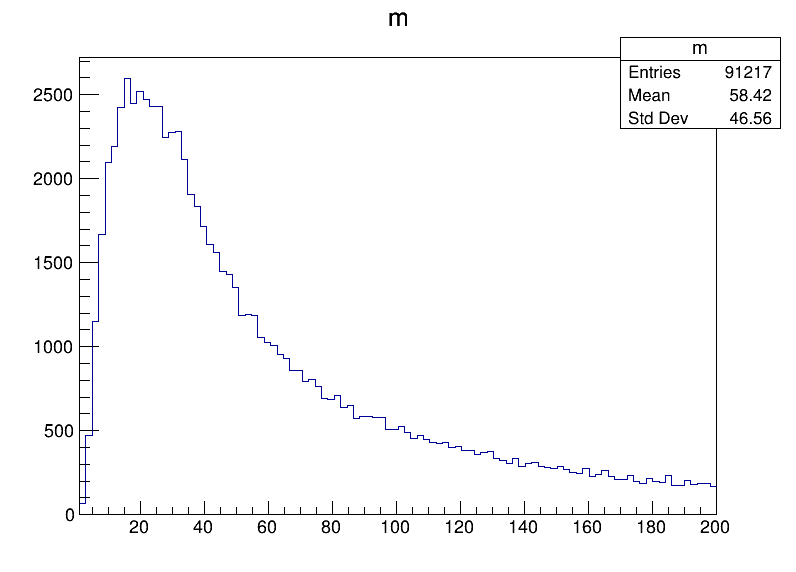

In [ ]:
import ROOT

histogram_pt= ROOT.TH1D("pT", "pT", 100,Qc,30)
histogram_m=  ROOT.TH1D("m", "m", 100,Qc,200)

for i in range(len(AllEmissions)):
    histogram_pt.Fill(ptarray[i])
    histogram_m.Fill(marray[i])


# Creare un canvas per disegnare l'istogramma
canvas = ROOT.TCanvas("canvas", "Canvas", 800, 600)

# Mostrare il canvas con l'istogramma
canvas.Update()
canvas.Draw()
histogram_m.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas


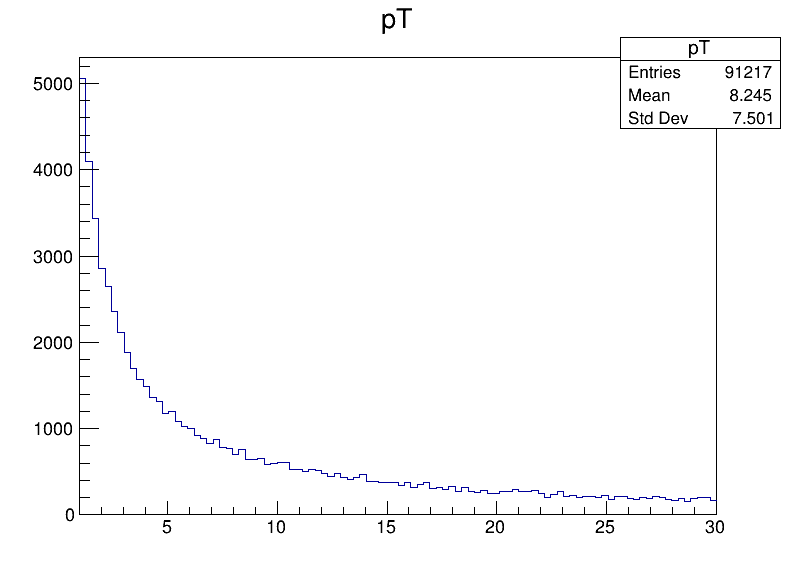

In [ ]:
canvas = ROOT.TCanvas("canvas", "Canvas", 800, 600)

# Disegnare l'istogramma
histogram_pt.Draw()
# Mostrare il canvas con l'istogramma
canvas.Update()
canvas.Draw()

